In [104]:
from torch_geometric.datasets import Planetoid, AttributedGraphDataset
import numpy as np
from torch_geometric.nn import GCNConv, GATConv, GCN, GAT, GraphSAGE, Node2Vec, GIN
from torch_geometric.explain import Explainer, GNNExplainer
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt

dataset1 = Planetoid('/tmp/cora', 'cora')
data1 = dataset1[0]

In [38]:
#split our dataset into train and test sets
def split_data(data, train_ratio=0.8):
    num_nodes = data.num_nodes
    shuffled_indices = np.random.permutation(num_nodes)
    train_indices = shuffled_indices[:int(train_ratio * num_nodes)]
    test_indices = shuffled_indices[int(train_ratio * num_nodes):]
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[train_indices] = True
    test_mask[test_indices] = True
    return train_mask, test_mask

data1.train_mask, data1.test_mask = split_data(data1)

6


In [ ]:
# class GCN(nn.Module):
#     # num_feature: input layer
#     # hidden_channels: number of channels in a layer
#     # num_layers: number of layers
#     # num_classes: output layer
#     def __init__(self, num_features, hidden_channels, num_layers, num_classes):
#         super(GCN, self).__init__()
#         self.convs = nn.ModuleList()
#         self.convs.append(GCNConv(num_features, hidden_channels))
#         for i in range(num_layers - 2):
#             self.convs.append(GCNConv(hidden_channels, hidden_channels))
#         self.convs.append(GCNConv(hidden_channels, num_classes))
#         self.act = nn.ReLU()
    
#     def forward(self, node_features, edge_index):
#         output = node_features
#         for conv in self.convs:
#             output = conv(output, edge_index)
#             output = self.act(output)
#         return output

In [ ]:
# # Graph Attention Network
# class GAT(nn.Module):
#     # num_feature: input layer
#     # hidden_channels: number of channels in a layer
#     # num_layers: number of layers
#     # num_classes: output layer
#     def __init__(self, num_features, hidden_channels, num_layers, num_classes):
#         super(GAT, self).__init__()
#         self.convs = nn.ModuleList()
#         self.convs.append(GATConv(num_features, hidden_channels))
#         for i in range(num_layers - 2):
#             self.convs.append(GATConv(hidden_channels, hidden_channels))
#         self.convs.append(GATConv(hidden_channels, num_classes))
#         self.act = nn.ReLU()
    
#     def forward(self, node_features, edge_index):
#         output = node_features
#         for conv in self.convs:
#             output = conv(output, edge_index)
#             output = self.act(output)
#         return output

In [108]:
def train(model, data, optimizer, loss):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    return loss

def test(model, data):
    model.eval()

    out = model(data.x, data.edge_index)
    _, pred = out.max(dim=1)
    
    train_err = 1 - pred[data.train_mask].eq(data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
    test_err = 1 - pred[data.test_mask].eq(data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()

    return train_err, test_err

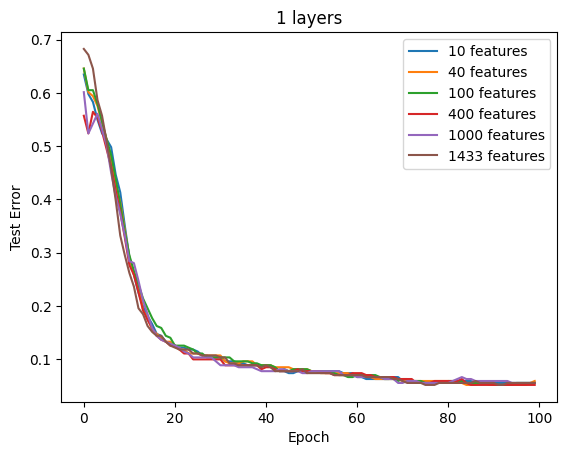

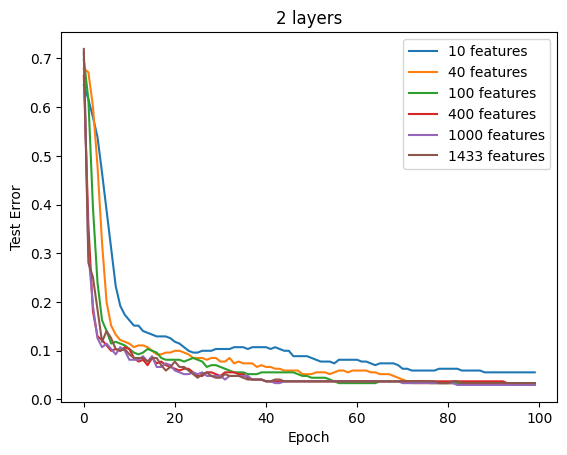

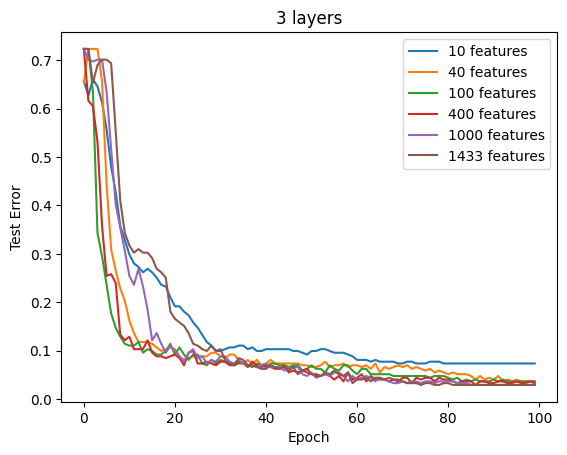

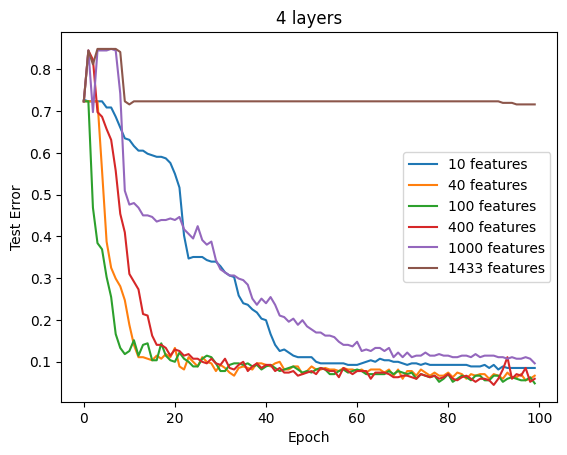

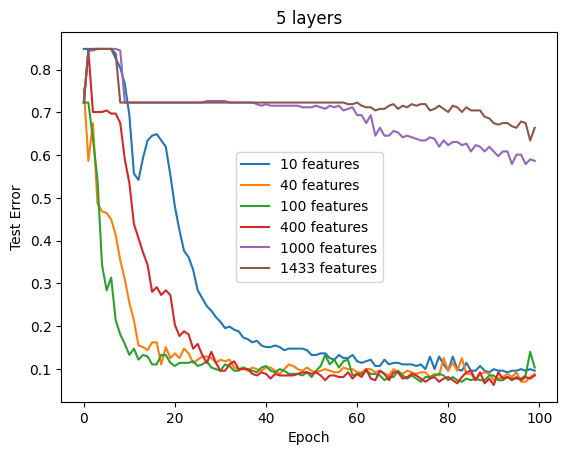

In [ ]:
#plot on five separate graphs: one for each number of layers; 5 separate graphs for each number of layers
def plot_layer(df, layer):
    sub_df = results_df[results_df['Layers'] == layer]
    for feature in features:
        df = sub_df[sub_df['Features'] == feature]
        plt.plot(df['Epoch'], df['Final Test Error'], label=f'{feature} features')
        plt.title(f'{layer} layers')
        plt.xlabel('Epoch')
        plt.ylabel('Test Error')
        plt.legend()
    plt.show()

for layer in layers:
    plot_layer(results_df, layer)


In [119]:
import pandas as pd

columns = ['Dataset', 'Model', 'Epoch', 'Channels', 'Layers', 'Test Error']
results_df = pd.DataFrame(columns=columns)

In [122]:
columns2 = ['Dataset', 'Model', 'Channels', 'Layers', 'Fidelity']
fidelity_df = pd.DataFrame(columns=columns2)

In [100]:
def train_GCN(data, num_classes, channels, layers, epochs, data_name):
    explainer_GCN_list = []
    for channel in channels:
        for layer in layers:
            model_GCN = GCN(data.num_features, channel, layer, num_classes)
            optimizer = optim.Adam(model_GCN.parameters(), lr=0.01)
            for epoch in range(epochs):
                loss = train(model_GCN, data, optimizer, nn.CrossEntropyLoss())
                train_err, test_err = test(model_GCN, data)

                results_df.append({'Dataset': data_name, 'Model': 'GCN', 'Epoch': epoch, 'Channels': channel, 'Layers': layer, 'Test Error': test_err}, ignore_index=True)
            
            #implement Explainer on GCN model
            explainer = Explainer(
                model=model_GCN,
                algorithm=GNNExplainer(epochs=200),
                explanation_type='model',
                node_mask_type='attributes',
                edge_mask_type='object',
                model_config=dict(
                    mode='multiclass_classification',
                    task_level='node',
                    return_type='log_probs',
                ),
            )
            explainer_GCN_list.append(explainer)
            print("GCN model with {} channels and {} layers trained".format(channel, layer))
    return explainer_GCN_list

In [88]:
def plot_GCN(data, explainer_GCN_list, channels, layers, j):
    for i in range(len(explainer_GCN_list)):
        explanation = explainer_GCN_list[i](data.x, data.edge_index)
        path = f'GCN_{j}/feature_importance_GCN_f_{channels[i // 4]}_l_{layers[i % 4]}.png'
        explanation.visualize_feature_importance(path, top_k=10)
        print(f"Feature importance plot has been saved to '{path}'")

In [67]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [89]:
channels = [10, 40, 100, 400]
layers = [1, 2, 3, 5]
epochs = 150

explainer_GCN_list = train_GCN(data1, dataset1.num_classes, channels, layers, epochs, 'Cora')
plot_GCN(data1, explainer_GCN_list, channels, layers, 1)

GCN model with 10 channels and 1 layers trained
GCN model with 10 channels and 2 layers trained
GCN model with 10 channels and 3 layers trained
GCN model with 10 channels and 5 layers trained
GCN model with 40 channels and 1 layers trained
GCN model with 40 channels and 2 layers trained
GCN model with 40 channels and 3 layers trained
GCN model with 40 channels and 5 layers trained
GCN model with 100 channels and 1 layers trained
GCN model with 100 channels and 2 layers trained
GCN model with 100 channels and 3 layers trained
GCN model with 100 channels and 5 layers trained
GCN model with 400 channels and 1 layers trained
GCN model with 400 channels and 2 layers trained
GCN model with 400 channels and 3 layers trained
GCN model with 400 channels and 5 layers trained
Feature importance plot has been saved to 'GCN_1/feature_importance_GCN_f_10_l_1.png'
Feature importance plot has been saved to 'GCN_1/feature_importance_GCN_f_10_l_2.png'
Feature importance plot has been saved to 'GCN_1/fea

In [99]:
def train_GAT(data, num_classes, channels, layers, epochs, data_name):
    explainer_GAT_list = []
    for channel in channels:
        for layer in layers:
            model_GAT = GAT(data.num_features, channel, layer, num_classes)
            optimizer = optim.Adam(model_GAT.parameters(), lr=0.01)
            for epoch in range(epochs):
                loss = train(model_GAT, data, optimizer, nn.CrossEntropyLoss())
                train_err, test_err = test(model_GAT, data)
            
                results_df.append({'Dataset': data_name, 'Model': 'GAT', 'Epoch': epoch, 'Channels': channel, 'Layers': layer, 'Test Error': test_err}, ignore_index=True)

            #implement Explainer on GAT model
            explainer = Explainer(
                model=model_GAT,
                algorithm=GNNExplainer(epochs=200),
                explanation_type='model',
                node_mask_type='attributes',
                edge_mask_type='object',
                model_config=dict(
                    mode='multiclass_classification',
                    task_level='node',
                    return_type='log_probs',
                ),
            )
            explainer_GAT_list.append(explainer)
            print("GAT model with {} channels and {} layers has been trained".format(channel, layer))
    return explainer_GAT_list

In [90]:
def plot_GAT(data, explainer_GAT_list, channels, layers, j):
    for i in range(len(explainer_GAT_list)):
        explanation = explainer_GAT_list[i](data.x, data.edge_index)
        path = f'GAT_{j}/feature_importance_GAT_f_{channels[i // 4]}_l_{layers[i % 4]}.png'
        explanation.visualize_feature_importance(path, top_k=10)
        print(f"Feature importance plot has been saved to '{path}'")

In [91]:
explainer_GAT_list = train_GAT(data1, dataset1.num_classes, channels, layers, epochs, "Cora")
plot_GAT(data1, explainer_GAT_list, channels, layers, 1)

GAT model with 10 channels and 1 layers has been trained
GAT model with 10 channels and 2 layers has been trained
GAT model with 10 channels and 3 layers has been trained
GAT model with 10 channels and 5 layers has been trained
GAT model with 40 channels and 1 layers has been trained
GAT model with 40 channels and 2 layers has been trained
GAT model with 40 channels and 3 layers has been trained
GAT model with 40 channels and 5 layers has been trained
GAT model with 100 channels and 1 layers has been trained
GAT model with 100 channels and 2 layers has been trained
GAT model with 100 channels and 3 layers has been trained
GAT model with 100 channels and 5 layers has been trained
GAT model with 400 channels and 1 layers has been trained
GAT model with 400 channels and 2 layers has been trained
GAT model with 400 channels and 3 layers has been trained
GAT model with 400 channels and 5 layers has been trained
Feature importance plot has been saved to 'GAT_1/feature_importance_GAT_f_10_l_1

In [73]:
from torch_geometric.loader import NeighborLoader

#inductive training function:
def train_inductive(model, data, train_loader, optimizer, loss_fn):
    #train model
    total_loss = total_correct = total_ex = 0

    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        y = batch.y[:batch.batch_size]
        pred = model(batch.x, batch.edge_index)[:batch.batch_size]
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.batch_size
        total_correct += pred.argmax(dim=-1).eq(y).sum().item()
        total_ex += batch.batch_size

    #return avg accuracy
    return total_loss / total_ex, total_correct / total_ex

def test_inductive(model, data):
    #test model
    model.eval()

    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=-1)
        train_err = 1.0 - pred[data.train_mask].eq(data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
        test_err = 1.0 - pred[data.test_mask].eq(data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    return train_err, test_err

In [98]:
neighbors_layer = [8, 5, 4, 3, 2]

def train_GraphSAGE(data, num_classes, channels, layers, epochs, data_name):
    #implement GraphSAGE model
    #split node features and labels into train and test sets
    explainer_GSG_list = []
    for channel in channels:
        for layer in layers:
            train_loader = NeighborLoader(data, batch_size = 256, shuffle=True, num_neighbors = neighbors_layer[:layer], input_nodes = data.train_mask)
            model_GSG = GraphSAGE(data.num_features, channel, layer, num_classes)
            optimizer = optim.Adam(model_GSG.parameters(), lr=0.01)
            for epoch in range(epochs):
                _, loss = train_inductive(model_GSG, data, train_loader, optimizer, nn.CrossEntropyLoss())
                train_err, test_err = test_inductive(model_GSG, data)

                results_df.append({'Dataset': data_name, 'Model': 'GraphSAGE', 'Epoch': epoch, 'Channels': channel, 'Layers': layer, 'Test Error': test_err}, ignore_index=True)

            print("Final Test Err: ", test_err)

            #implement Explainer on GAT model
            explainer = Explainer(
                model=model_GSG,
                algorithm=GNNExplainer(epochs=200),
                explanation_type='model',
                node_mask_type='attributes',
                edge_mask_type='object',
                model_config=dict(
                    mode='multiclass_classification',
                    task_level='node',
                    return_type='log_probs',
                ),
            )
            explainer_GSG_list.append(explainer)
            print("GraphSAGE model with {} channels and {} layers has been trained".format(channel, layer))
    return explainer_GSG_list

In [92]:
def plot_GraphSAGE(data, explainer_GSG_list, channels, layers, j):
    for i in range(len(explainer_GSG_list)):
        explanation = explainer_GSG_list[i](data.x, data.edge_index)
        path = f'GraphSAGE_{j}/feature_importance_GraphSAGE_f_{channels[i // 4]}_l_{layers[i % 4]}.png'
        explanation.visualize_feature_importance(path, top_k=10)
        print(f"Feature importance plot has been saved to '{path}'")

In [93]:
explainer_GSG_list = train_GraphSAGE(data1, dataset1.num_classes, channels, layers, epochs, "Cora")
plot_GraphSAGE(data1, explainer_GSG_list, channels, layers, 1)

Final Test Err:  0.12730627306273068
GAT model with 10 channels and 1 layers has been trained
Final Test Err:  0.11439114391143912
GAT model with 10 channels and 2 layers has been trained
Final Test Err:  0.11808118081180807
GAT model with 10 channels and 3 layers has been trained
Final Test Err:  0.16605166051660514
GAT model with 10 channels and 5 layers has been trained
Final Test Err:  0.12730627306273068
GAT model with 40 channels and 1 layers has been trained
Final Test Err:  0.10885608856088558
GAT model with 40 channels and 2 layers has been trained
Final Test Err:  0.1162361623616236
GAT model with 40 channels and 3 layers has been trained
Final Test Err:  0.14760147601476015
GAT model with 40 channels and 5 layers has been trained
Final Test Err:  0.12177121771217714
GAT model with 100 channels and 1 layers has been trained
Final Test Err:  0.11439114391143912
GAT model with 100 channels and 2 layers has been trained
Final Test Err:  0.10885608856088558
GAT model with 100 cha

In [120]:
dataset2 = AttributedGraphDataset(root='data/Wiki', name='Wiki')
data2 = dataset2[0]

#implement GCN/GAT/GraphSAGE models
#split node features and labels into train and test sets
channels = [10, 40, 100, 400]
layers = [1, 2, 3, 5]
epochs = 150

data2.train_mask, data2.test_mask = split_data(data2)
explainer_GCN_list_2 = train_GCN(data2, dataset2.num_classes, channels, layers, epochs, "Wiki")
plot_GCN(data2, explainer_GCN_list_2, channels, layers, 2)

explainer_GAT_list_2 = train_GAT(data2, dataset2.num_classes, channels, layers, epochs, "Wiki")
plot_GAT(data2, explainer_GAT_list_2, channels, layers, 2)

explainer_GSG_list_2 = train_GraphSAGE(data2, dataset2.num_classes, channels, layers, epochs, "Wiki")
plot_GraphSAGE(data2, explainer_GSG_list_2, channels, layers, 2)

GCN model with 10 channels and 1 layers trained
GCN model with 10 channels and 2 layers trained
GCN model with 10 channels and 3 layers trained
GCN model with 10 channels and 5 layers trained
GCN model with 40 channels and 1 layers trained
GCN model with 40 channels and 2 layers trained
GCN model with 40 channels and 3 layers trained
GCN model with 40 channels and 5 layers trained
GCN model with 100 channels and 1 layers trained
GCN model with 100 channels and 2 layers trained
GCN model with 100 channels and 3 layers trained
GCN model with 100 channels and 5 layers trained
GCN model with 400 channels and 1 layers trained
GCN model with 400 channels and 2 layers trained
GCN model with 400 channels and 3 layers trained
GCN model with 400 channels and 5 layers trained
Feature importance plot has been saved to 'GCN_2/feature_importance_GCN_f_10_l_1.png'
Feature importance plot has been saved to 'GCN_2/feature_importance_GCN_f_10_l_2.png'
Feature importance plot has been saved to 'GCN_2/fea

In [121]:
explainer_GCN_list = train_GCN(data1, dataset1.num_classes, channels, layers, epochs, 'Cora')
explainer_GAT_list = train_GAT(data1, dataset1.num_classes, channels, layers, epochs, "Cora")
explainer_GSG_list = train_GraphSAGE(data1, dataset1.num_classes, channels, layers, epochs, "Cora")

GCN model with 10 channels and 1 layers trained
GCN model with 10 channels and 2 layers trained
GCN model with 10 channels and 3 layers trained
GCN model with 10 channels and 5 layers trained
GCN model with 40 channels and 1 layers trained
GCN model with 40 channels and 2 layers trained
GCN model with 40 channels and 3 layers trained
GCN model with 40 channels and 5 layers trained
GCN model with 100 channels and 1 layers trained
GCN model with 100 channels and 2 layers trained
GCN model with 100 channels and 3 layers trained
GCN model with 100 channels and 5 layers trained
GCN model with 400 channels and 1 layers trained
GCN model with 400 channels and 2 layers trained
GCN model with 400 channels and 3 layers trained
GCN model with 400 channels and 5 layers trained
GAT model with 10 channels and 1 layers has been trained
GAT model with 10 channels and 2 layers has been trained
GAT model with 10 channels and 3 layers has been trained
GAT model with 10 channels and 5 layers has been trai

In [147]:
from torch_geometric.explain import fidelity

def calc_fidelity(data, explainer_list):
    fidelity_list = []
    #calculate fidelity for each model
    for i in range(len(explainer_list)):
        explanation = explainer_list[i](data.x, data.edge_index)
        fid = fidelity(explainer_list[i], explanation)
        fidelity_list.append(fid)
        print(i)
    return fidelity_list

In [148]:
fidelity_GCN_1 = calc_fidelity(data1, explainer_GCN_list)
fidelity_GAT_1 = calc_fidelity(data1, explainer_GAT_list)
fidelity_GSG_1 = calc_fidelity(data1, explainer_GSG_list)

In [164]:
#avg positive fidelity for each model
fidelity_GCN_1_avg = np.mean(fidelity_GCN_1, axis=0)
fidelity_GAT_1_avg = np.mean(fidelity_GAT_1, axis=0)
fidelity_GSG_1_avg = np.mean(fidelity_GSG_1, axis=0)

#std_dev fidelity for each model
fidelity_GCN_1_std = np.std(fidelity_GCN_1, axis=0)
fidelity_GAT_1_std = np.std(fidelity_GAT_1, axis=0)
fidelity_GSG_1_std = np.std(fidelity_GSG_1, axis=0)


In [166]:
print(fidelity_GCN_1_avg)
print(fidelity_GAT_1_avg)
print(fidelity_GSG_1_avg)

print(fidelity_GCN_1_std)
print(fidelity_GAT_1_std)
print(fidelity_GSG_1_std)

[0.74889216 0.17475997]
[0.55917649 0.42854506]
[0.77381831 0.18639217]
[0.11676752 0.12564982]
[0.08571718 0.20083628]
[0.0639272  0.16114949]
